In [1]:
from Net import Autoencoder,GANomaly
import torch
import torch.nn as nn
from AuxiliaryFunctions import save_checkpoint, save_recon, fig_to_img,get_plottable_frame
from VideoDataset import VideoDataset
from VideoTransforms import *
from torch.utils.data import DataLoader
from torchvision import transforms
from timeit import default_timer as timer
from datetime import datetime
import matplotlib.pyplot as plt
import os
from pathlib import Path, PureWindowsPath
from collections import OrderedDict
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import pickle

In [2]:
def train(model,train_loader,val_loader, device, num_epochs,directory, learning_rate=1e-3,model_name='model',checkpoint=[]):
    torch.manual_seed(42)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=25,min_lr=1e-7,verbose=True)
    start_idx = 0
    epoch_losses = {}
    val_losses = {}
    if isinstance(checkpoint,dict):
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        optimizer.lr=learning_rate
        try:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        except KeyError:
            print('scheduler not found')
        start_idx = checkpoint['epoch']
    for epoch in range(start_idx,num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()
            clips = data['clip'].to(device)
            reconstruction = model(clips)
            loss = criterion(clips,reconstruction)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*clips.size(0)
            if i % 500 == 0:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
        
        epoch_losses[epoch]=running_loss/len(train_loader.dataset)
        #evaluate the validation data set:
        with torch.no_grad():
            val_loss = 0.0
            for j,vdata in enumerate(val_loader):
                val_clips=vdata['clip'].to(device)
                val_recon = model(val_clips)
                val_loss += criterion(val_clips,val_recon)*val_clips.size(0)
            val_losses[epoch]= val_loss/len(val_loader.dataset)  
        print(f'Train loss: {epoch_losses[epoch]}, Validation loss: {val_losses[epoch]}')
        # step the scheduler
        scheduler.step(val_losses[epoch])
        save_checkpoint(model,optimizer,epoch,train_loss=epoch_losses[epoch],scheduler_state_dict=scheduler.state_dict(),
                        val_loss=val_losses[epoch],directory=directory,name=model_name)
        save_recon(reconstruction,model_name,epoch,directory)
    return epoch_losses, val_losses


In [3]:
directory_train='G:/My Drive/PhD/Fishbase/SwimVSFeed/New_DB/photos/optic_flow_train_fish2/'
#'/Volumes/GoogleDrive/My Drive/PhD/cut_swim_samples'
ds_train=VideoDataset(directory_train,num_frames=100, 
                transform=transforms.Compose([Rescale(256),RandomHorizontalFlip(0.5),RandomVerticalFlip(0.3),
                                              ToTensor()]),color_channels=2)
dataloader_train = DataLoader(ds_train, batch_size=4,
                        shuffle=True, num_workers=12)
directory_val='G:/My Drive/PhD/Fishbase/SwimVSFeed/New_DB/photos/optic_flow_validation_fish2/'
ds_val=VideoDataset(directory_val,num_frames=100, 
                transform=transforms.Compose([Rescale(256),ToTensor()]),color_channels=2)
dataloader_val = DataLoader(ds_val, batch_size=4,
                        shuffle=False, num_workers=2)
print(len(ds_train),len(ds_val),len(dataloader_train.dataset))

119 21 119


In [12]:
clip=np.squeeze(ds_train[0]['clip'])
clip = np.transpose(clip, (1,2,3,0))
print(clip.shape)
tmp = np.ones((clip.shape[0],clip.shape[1],clip.shape[2],3))*0.5
for i in range(clip.shape[0]):
    tmp[i,:,:,:-1]= clip[i,:,:]
from moviepy.editor import ImageSequenceClip
#flow_gif = ImageSequenceClip(list((clip[:,:,:,np.newaxis]).astype(np.uint8)), fps=20)    
#flow_gif = ImageSequenceClip(list((255*flow4).astype(np.uint8)), fps=20) 
flow_gif = ImageSequenceClip(list((255*tmp).astype(np.uint8)), fps=20) 
flow_gif.write_gif('G:/My Drive/PhD/Fishbase/SwimVSFeed/terset.gif', fps=20)

torch.Size([100, 256, 256, 2])


t:  16%|█▌        | 16/100 [00:00<00:00, 159.23it/s, now=None]

MoviePy - Building file G:/My Drive/PhD/Fishbase/SwimVSFeed/terset.gif with imageio.


In [6]:

path = 'G:/My Drive/PhD/Fishbase/SwimVSFeed/New_DB/models/ds_optical_flow_fish2/autoencoder_150221_epoch199.pt'
checkpoint=torch.load(path)

torch.Size([177, 1, 20, 256, 256])

In [7]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
model = Net(color_channels=2)
model.to(device)
start = timer()
run_loss,val_loss=train(model,dataloader_train,dataloader_val,device,num_epochs=300, 
               directory='G:/My Drive/PhD/Fishbase/SwimVSFeed/New_DB/models/ds_optical_flow_fish2' ,
               learning_rate= 0.001,
               model_name='autoencoder_150221',checkpoint=checkpoint)
end = timer()
print(f'elapsed training time {end-start} sec')

[200,     1] loss: 0.006


KeyboardInterrupt: 

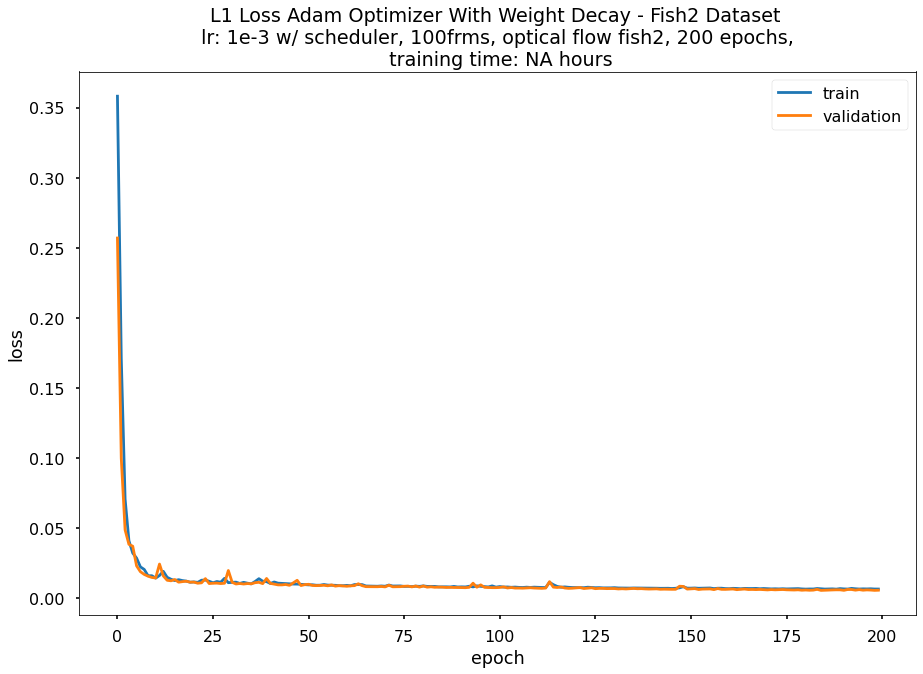

In [11]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(15,10))
    plt.plot(list(run_loss.keys()),(list(run_loss.values())))
    plt.plot(list(val_loss.keys()),(list(val_loss.values())))
    plt.legend(['train','validation'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('L1 Loss Adam Optimizer With Weight Decay - Fish2 Dataset \n lr: 1e-3 w/ scheduler, 100frms, optical flow fish2, 200 epochs, \n training time: NA hours')
    plt.savefig('G:/My Drive/PhD/Fishbase/SwimVSFeed/New_DB/models/ds_optical_flow_fish2/full_ds_lossvsepoch.png' )

In [35]:
directory=str(Path('G:/My Drive/PhD/regularvid2'))#'/Volumes/GoogleDrive/My Drive/PhD/regularvid'##
#'/Volumes/GoogleDrive/My Drive/PhD/cut_swim_samples'
ds=VideoDataset(directory,num_frames=20, 
                transform=transforms.Compose([Rescale(256),ToTensor()]),swim_sample=False)
dataloader = DataLoader(ds, batch_size=4,
                        shuffle=False, num_workers=4)

In [37]:
path=str(Path('G:/My Drive/PhD/regularvid2/l2_set_lr_weight_decay/model_overfit_071220_20frms_l2_adam_wd_epoch1998.pt'))
#'/Volumes/GoogleDrive/My Drive/PhD/fish_vid/set learning rate w weight decay/model_overfit_261120_20frms_epoch1999.pt'
#'/Volumes/GoogleDrive/My Drive/PhD/regularvid/model_overfit_291120_20frms_epoch2999.pt'#str(Path('G:/My Drive/PhD/regularvid/model_overfit_291120_20frms_epoch2999.pt'))
checkpoint=torch.load(path)#,map_location=torch.device('cpu'))


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
directory=str(Path('G:/My Drive/PhD/regularvid2/l2_set_lr_weight_decay'))
model = Net(color_channels=1)
model.to(device)
start = timer()
run_loss=train(model,dataloader,device,num_epochs=4000, directory=directory,batch_size=4,
               learning_rate=1e-4,
               model_name='model_overfit_071220_20frms_l2_adam_wd', checkpoint=checkpoint)
end = timer()
print(f'elapsed training time {end-start} sec')

[1999,     1] loss: 0.005
0.005405931733548641
[2000,     1] loss: 0.005
0.005396625027060509
[2001,     1] loss: 0.005
0.0053543210960924625
[2002,     1] loss: 0.005
0.0053992001339793205
[2003,     1] loss: 0.005
0.005334601737558842
[2004,     1] loss: 0.005
0.0053314585238695145
[2005,     1] loss: 0.005
0.00530586251989007
[2006,     1] loss: 0.005
0.005273555405437946
[2007,     1] loss: 0.005
0.005284027196466923
[2008,     1] loss: 0.005
0.0052910554222762585
[2009,     1] loss: 0.005
0.005279222968965769
[2010,     1] loss: 0.005
0.0053139375522732735
[2011,     1] loss: 0.005
0.005267842207103968
[2012,     1] loss: 0.005
0.005270906258374453
[2013,     1] loss: 0.005
0.00530204689130187
[2014,     1] loss: 0.006
0.005549796856939793
[2015,     1] loss: 0.005
0.005257090087980032
[2016,     1] loss: 0.005
0.005254716146737337
[2017,     1] loss: 0.005
0.005247016903012991
[2018,     1] loss: 0.005
0.00525523629039526
[2019,     1] loss: 0.005
0.005243376363068819
[2020,     

0.005038175266236067
[2174,     1] loss: 0.005
0.005053811240941286
[2175,     1] loss: 0.005
0.005077021196484566
[2176,     1] loss: 0.005
0.00514094578102231
[2177,     1] loss: 0.005
0.0051712701097130775
[2178,     1] loss: 0.005
0.005317118484526873
[2179,     1] loss: 0.005
0.005304964259266853
[2180,     1] loss: 0.005
0.005145976785570383
[2181,     1] loss: 0.005
0.005107607692480087
[2182,     1] loss: 0.005
0.005099911708384752
[2183,     1] loss: 0.005
0.005095755215734243
[2184,     1] loss: 0.005
0.005087364464998245
[2185,     1] loss: 0.005
0.0050866506062448025
[2186,     1] loss: 0.005
0.005063177086412907
[2187,     1] loss: 0.005
0.005049395840615034
[2188,     1] loss: 0.005
0.005033482331782579
[2189,     1] loss: 0.005
0.0050237951800227165
[2190,     1] loss: 0.005
0.005012464243918657
[2191,     1] loss: 0.005
0.005003051366657019
[2192,     1] loss: 0.005
0.005007584113627672
[2193,     1] loss: 0.005
0.005014366470277309
[2194,     1] loss: 0.005
0.005003180

[2348,     1] loss: 0.007
0.00710765365511179
[2349,     1] loss: 0.007
0.006623531691730022
[2350,     1] loss: 0.007
0.0073590935207903385
[2351,     1] loss: 0.006
0.006276484113186598
[2352,     1] loss: 0.007
0.006662910804152489
[2353,     1] loss: 0.006
0.006146998144686222
[2354,     1] loss: 0.006
0.006319408770650625
[2355,     1] loss: 0.007
0.006544407922774553
[2356,     1] loss: 0.006
0.005868017207831144
[2357,     1] loss: 0.006
0.006193199660629034
[2358,     1] loss: 0.006
0.005838068667799234
[2359,     1] loss: 0.006
0.00591463316231966
[2360,     1] loss: 0.006
0.005727626383304596
[2361,     1] loss: 0.006
0.005787499248981476
[2362,     1] loss: 0.006
0.005726901814341545
[2363,     1] loss: 0.006
0.005705459509044886
[2364,     1] loss: 0.006
0.005592831876128912
[2365,     1] loss: 0.006
0.005532089155167341
[2366,     1] loss: 0.006
0.005548413377255201
[2367,     1] loss: 0.005
0.0054805888794362545
[2368,     1] loss: 0.005
0.005478922743350267
[2369,     1]

0.004623487126082182
[2523,     1] loss: 0.005
0.00462158489972353
[2524,     1] loss: 0.005
0.004612364340573549
[2525,     1] loss: 0.005
0.004606062546372414
[2526,     1] loss: 0.005
0.004607649520039558
[2527,     1] loss: 0.005
0.004611922428011894
[2528,     1] loss: 0.005
0.004601974971592426
[2529,     1] loss: 0.005
0.0046094260178506374
[2530,     1] loss: 0.005
0.004618625156581402
[2531,     1] loss: 0.005
0.0046202559024095535
[2532,     1] loss: 0.005
0.00462695537135005
[2533,     1] loss: 0.005
0.004620127379894257
[2534,     1] loss: 0.005
0.004624948371201754
[2535,     1] loss: 0.005
0.004623499233275652
[2536,     1] loss: 0.005
0.004617798142135143
[2537,     1] loss: 0.005
0.004624094348400831
[2538,     1] loss: 0.005
0.004619939252734184
[2539,     1] loss: 0.005
0.004629537463188171
[2540,     1] loss: 0.005
0.004624687600880861
[2541,     1] loss: 0.005
0.004631862975656986
[2542,     1] loss: 0.005
0.0046323006972670555
[2543,     1] loss: 0.005
0.0046360301

0.00451236218214035
[2697,     1] loss: 0.005
0.004507993347942829
[2698,     1] loss: 0.005
0.00450509786605835
[2699,     1] loss: 0.005
0.004507263191044331
[2700,     1] loss: 0.004
0.00449543260037899
[2701,     1] loss: 0.005
0.0045007141306996346
[2702,     1] loss: 0.005
0.004506980534642935
[2703,     1] loss: 0.005
0.0045145726762712
[2704,     1] loss: 0.005
0.004542715381830931
[2705,     1] loss: 0.005
0.004521852824836969
[2706,     1] loss: 0.005
0.004556269384920597
[2707,     1] loss: 0.005
0.004579688422381878
[2708,     1] loss: 0.005
0.004613131750375032
[2709,     1] loss: 0.005
0.0046373638324439526
[2710,     1] loss: 0.005
0.004744267091155052
[2711,     1] loss: 0.005
0.004839200060814619
[2712,     1] loss: 0.005
0.0049853031523525715
[2713,     1] loss: 0.005
0.005075209308415651
[2714,     1] loss: 0.005
0.005036696791648865
[2715,     1] loss: 0.005
0.004807501565665007
[2716,     1] loss: 0.005
0.0045682103373110294
[2717,     1] loss: 0.005
0.004552309401

[2871,     1] loss: 0.005
0.00472826324403286
[2872,     1] loss: 0.005
0.004636445548385382
[2873,     1] loss: 0.005
0.004641394596546888
[2874,     1] loss: 0.005
0.004581937566399574
[2875,     1] loss: 0.005
0.004667504224926233
[2876,     1] loss: 0.005
0.004534186329692602
[2877,     1] loss: 0.005
0.004574346821755171
[2878,     1] loss: 0.005
0.004506167024374008
[2879,     1] loss: 0.005
0.004555117338895798
[2880,     1] loss: 0.004
0.004488695878535509
[2881,     1] loss: 0.004
0.004486418794840574
[2882,     1] loss: 0.004
0.004465712700039148
[2883,     1] loss: 0.004
0.0044626048766076565
[2884,     1] loss: 0.004
0.004491547122597694
[2885,     1] loss: 0.004
0.004476320464164019
[2886,     1] loss: 0.005
0.004518204368650913
[2887,     1] loss: 0.005
0.004502349998801947
[2888,     1] loss: 0.004
0.00447898218408227
[2889,     1] loss: 0.004
0.004460074007511139
[2890,     1] loss: 0.004
0.004454412497580051
[2891,     1] loss: 0.004
0.004423904698342085
[2892,     1] 

0.004323964472860098
[3046,     1] loss: 0.004
0.004319744650274515
[3047,     1] loss: 0.004
0.00432939175516367
[3048,     1] loss: 0.004
0.004325257148593664
[3049,     1] loss: 0.004
0.004331690724939108
[3050,     1] loss: 0.004
0.004322438966482878
[3051,     1] loss: 0.004
0.004326439928263426
[3052,     1] loss: 0.004
0.004331444855779409
[3053,     1] loss: 0.004
0.004322566092014313
[3054,     1] loss: 0.004
0.00433044508099556
[3055,     1] loss: 0.004
0.0043287440203130245
[3056,     1] loss: 0.004
0.004328965209424496
[3057,     1] loss: 0.004
0.004327281378209591
[3058,     1] loss: 0.004
0.00432298518717289
[3059,     1] loss: 0.004
0.004327555652707815
[3060,     1] loss: 0.004
0.004341581370681524
[3061,     1] loss: 0.004
0.004347230773419142
[3062,     1] loss: 0.004
0.004359647631645203
[3063,     1] loss: 0.004
0.004350204952061176
[3064,     1] loss: 0.004
0.004352663177996874
[3065,     1] loss: 0.004
0.0043519181199371815
[3066,     1] loss: 0.004
0.004355216864

[3220,     1] loss: 0.004
0.004130318760871887
[3221,     1] loss: 0.004
0.004146148916333914
[3222,     1] loss: 0.004
0.0041341641917824745
[3223,     1] loss: 0.004
0.004135346505790949
[3224,     1] loss: 0.004
0.004134252201765776
[3225,     1] loss: 0.004
0.004137758165597916
[3226,     1] loss: 0.004
0.004141648765653372
[3227,     1] loss: 0.004
0.004139848053455353
[3228,     1] loss: 0.004
0.004168135579675436
[3229,     1] loss: 0.004
0.004168578889220953
[3230,     1] loss: 0.004
0.004162984900176525
[3231,     1] loss: 0.004
0.004167845938354731
[3232,     1] loss: 0.004
0.004183732904493809
[3233,     1] loss: 0.004
0.0041846055537462234
[3234,     1] loss: 0.004
0.004185782745480537
[3235,     1] loss: 0.004
0.004197876900434494
[3236,     1] loss: 0.004
0.004179998300969601
[3237,     1] loss: 0.004
0.004183667711913586
[3238,     1] loss: 0.004
0.004177666734904051
[3239,     1] loss: 0.004
0.004174729809165001
[3240,     1] loss: 0.004
0.004174725618213415
[3241,     

0.00406919838860631
[3395,     1] loss: 0.004
0.004062945954501629
[3396,     1] loss: 0.004
0.0039881812408566475
[3397,     1] loss: 0.004
0.00406997837126255
[3398,     1] loss: 0.004
0.0040835365653038025
[3399,     1] loss: 0.004
0.0040140412747859955
[3400,     1] loss: 0.004
0.003981254529207945
[3401,     1] loss: 0.004
0.0040267216973006725
[3402,     1] loss: 0.004
0.004003159236162901
[3403,     1] loss: 0.004
0.00400070333853364
[3404,     1] loss: 0.004
0.00399184413254261
[3405,     1] loss: 0.004
0.003991280682384968
[3406,     1] loss: 0.004
0.004010481294244528
[3407,     1] loss: 0.004
0.0039681908674538136
[3408,     1] loss: 0.004
0.003984545823186636
[3409,     1] loss: 0.004
0.004007529467344284
[3410,     1] loss: 0.004
0.003981499467045069
[3411,     1] loss: 0.004
0.003973034210503101
[3412,     1] loss: 0.004
0.003985532559454441
[3413,     1] loss: 0.004
0.0039725229144096375
[3414,     1] loss: 0.004
0.0039729042910039425
[3415,     1] loss: 0.004
0.00396950

0.003921201918274164
[3569,     1] loss: 0.004
0.003914243075996637
[3570,     1] loss: 0.004
0.003917659167200327
[3571,     1] loss: 0.004
0.003938712179660797
[3572,     1] loss: 0.004
0.003945430740714073
[3573,     1] loss: 0.004
0.004013864789158106
[3574,     1] loss: 0.004
0.0039676218293607235
[3575,     1] loss: 0.004
0.004022276494652033
[3576,     1] loss: 0.004
0.003956458996981382
[3577,     1] loss: 0.004
0.003953579347580671
[3578,     1] loss: 0.004
0.003958446439355612
[3579,     1] loss: 0.004
0.003982951864600182
[3580,     1] loss: 0.004
0.004066654480993748
[3581,     1] loss: 0.004
0.004236951936036348
[3582,     1] loss: 0.004
0.004381953738629818
[3583,     1] loss: 0.005
0.004761079791933298
[3584,     1] loss: 0.005
0.004702386446297169
[3585,     1] loss: 0.005
0.004801863804459572
[3586,     1] loss: 0.005
0.004526831209659576
[3587,     1] loss: 0.004
0.004231023136526346
[3588,     1] loss: 0.004
0.00429009273648262
[3589,     1] loss: 0.004
0.00437412224

[3742,     1] loss: 0.004
0.003776791738346219
[3743,     1] loss: 0.004
0.0037963520735502243
[3744,     1] loss: 0.004
0.00377847533673048
[3745,     1] loss: 0.004
0.0037889936938881874
[3746,     1] loss: 0.004
0.003754992503672838
[3747,     1] loss: 0.004
0.0037615580949932337
[3748,     1] loss: 0.004
0.0037501680199056864
[3749,     1] loss: 0.004
0.003769615897908807
[3750,     1] loss: 0.004
0.003764429362490773
[3751,     1] loss: 0.004
0.0037622416857630014
[3752,     1] loss: 0.004
0.0037894556298851967
[3753,     1] loss: 0.004
0.003752628341317177
[3754,     1] loss: 0.004
0.003769676201045513
[3755,     1] loss: 0.004
0.0037486092187464237
[3756,     1] loss: 0.004
0.003755093552172184
[3757,     1] loss: 0.004
0.003723969915881753
[3758,     1] loss: 0.004
0.0037167342379689217
[3759,     1] loss: 0.004
0.003718577092513442
[3760,     1] loss: 0.004
0.0037170241121202707
[3761,     1] loss: 0.004
0.0037364955060184
[3762,     1] loss: 0.004
0.0037226583808660507
[3763,

0.004069483373314142
[3915,     1] loss: 0.004
0.0040726205334067345
[3916,     1] loss: 0.004
0.004100067541003227
[3917,     1] loss: 0.004
0.004156050272285938
[3918,     1] loss: 0.004
0.004106480162590742
[3919,     1] loss: 0.004
0.0039360858500003815
[3920,     1] loss: 0.004
0.004024178721010685
[3921,     1] loss: 0.004
0.004051545634865761
[3922,     1] loss: 0.004
0.004008716903626919
[3923,     1] loss: 0.004
0.0038764632772654295
[3924,     1] loss: 0.004
0.003954640589654446
[3925,     1] loss: 0.004
0.003940518945455551
[3926,     1] loss: 0.004
0.00388727686367929
[3927,     1] loss: 0.004
0.0038822966162115335
[3928,     1] loss: 0.004
0.003872643457725644
[3929,     1] loss: 0.004
0.003871473018079996
[3930,     1] loss: 0.004
0.00381861231289804
[3931,     1] loss: 0.004
0.003820886369794607
[3932,     1] loss: 0.004
0.003853104542940855
[3933,     1] loss: 0.004
0.003829394467175007
[3934,     1] loss: 0.004
0.0038174819201231003
[3935,     1] loss: 0.004
0.00381631

In [36]:
for root, directories, files in os.walk(directory):
    print(root)
    print(directories)
    for filename in files:
        print(filename)

frame = ds[0]['clip'][1,:,:,:]
new_h, new_w = int(256*frame.shape[0]/frame.shape[1]), 256


G:\My Drive\PhD\regularvid
['New folder', '800epochs', 'New Folder With Items', 'mod_lr']
vid1.mp4
vid1.avi
model_overfit_291120_20frms_epoch0.pt
model_overfit_291120_20frms_epoch0.jpg
model_overfit_291120_20frms_epoch1.pt
model_overfit_291120_20frms_epoch1.jpg
model_overfit_291120_20frms_epoch2.pt
model_overfit_291120_20frms_epoch2.jpg
model_overfit_291120_20frms_epoch3.pt
model_overfit_291120_20frms_epoch3.jpg
model_overfit_291120_20frms_epoch4.pt
model_overfit_291120_20frms_epoch4.jpg
model_overfit_291120_20frms_epoch5.pt
model_overfit_291120_20frms_epoch5.jpg
model_overfit_291120_20frms_epoch6.pt
model_overfit_291120_20frms_epoch6.jpg
model_overfit_291120_20frms_epoch7.pt
model_overfit_291120_20frms_epoch7.jpg
model_overfit_291120_20frms_epoch8.pt
model_overfit_291120_20frms_epoch8.jpg
model_overfit_291120_20frms_epoch9.pt
model_overfit_291120_20frms_epoch9.jpg
model_overfit_291120_20frms_epoch10.pt
model_overfit_291120_20frms_epoch10.jpg
model_overfit_291120_20frms_epoch11.pt
mode

model_overfit_241120_20frms_epoch45.pt
model_overfit_241120_20frms_epoch45.jpg
model_overfit_241120_20frms_epoch46.pt
model_overfit_241120_20frms_epoch46.jpg
model_overfit_241120_20frms_epoch47.pt
model_overfit_241120_20frms_epoch47.jpg
model_overfit_241120_20frms_epoch48.pt
model_overfit_241120_20frms_epoch48.jpg
model_overfit_241120_20frms_epoch49.pt
model_overfit_241120_20frms_epoch49.jpg
model_overfit_241120_20frms_epoch50.pt
model_overfit_241120_20frms_epoch50.jpg
model_overfit_241120_20frms_epoch51.pt
model_overfit_241120_20frms_epoch51.jpg
model_overfit_241120_20frms_epoch52.pt
model_overfit_241120_20frms_epoch52.jpg
model_overfit_241120_20frms_epoch53.pt
model_overfit_241120_20frms_epoch53.jpg
model_overfit_241120_20frms_epoch54.pt
model_overfit_241120_20frms_epoch54.jpg
model_overfit_241120_20frms_epoch55.pt
model_overfit_241120_20frms_epoch55.jpg
model_overfit_241120_20frms_epoch56.pt
model_overfit_241120_20frms_epoch56.jpg
model_overfit_241120_20frms_epoch57.pt
model_overfit

G:\My Drive\PhD\regularvid\New Folder With Items
[]
model_overfit_241120_20frms_epoch0.pt
model_overfit_241120_20frms_epoch0.jpg
model_overfit_241120_20frms_epoch1.pt
model_overfit_241120_20frms_epoch1.jpg
model_overfit_241120_20frms_epoch2.pt
model_overfit_241120_20frms_epoch2.jpg
model_overfit_241120_20frms_epoch3.pt
model_overfit_241120_20frms_epoch3.jpg
model_overfit_241120_20frms_epoch4.pt
model_overfit_241120_20frms_epoch4.jpg
model_overfit_241120_20frms_epoch5.pt
model_overfit_241120_20frms_epoch5.jpg
model_overfit_241120_20frms_epoch6.pt
model_overfit_241120_20frms_epoch6.jpg
model_overfit_241120_20frms_epoch7.pt
model_overfit_241120_20frms_epoch7.jpg
model_overfit_241120_20frms_epoch8.pt
model_overfit_241120_20frms_epoch8.jpg
model_overfit_241120_20frms_epoch9.pt
model_overfit_241120_20frms_epoch9.jpg
model_overfit_241120_20frms_epoch10.pt
model_overfit_241120_20frms_epoch10.jpg
model_overfit_241120_20frms_epoch11.pt
model_overfit_241120_20frms_epoch11.jpg
model_overfit_241120

model_overfit_241120_20frms_epoch870.pt
model_overfit_241120_20frms_epoch870.jpg
model_overfit_241120_20frms_epoch871.pt
model_overfit_241120_20frms_epoch871.jpg
model_overfit_241120_20frms_epoch872.pt
model_overfit_241120_20frms_epoch872.jpg
model_overfit_241120_20frms_epoch873.pt
model_overfit_241120_20frms_epoch873.jpg
model_overfit_241120_20frms_epoch874.pt
model_overfit_241120_20frms_epoch874.jpg
model_overfit_241120_20frms_epoch875.pt
model_overfit_241120_20frms_epoch875.jpg
model_overfit_241120_20frms_epoch876.pt
model_overfit_241120_20frms_epoch876.jpg
model_overfit_241120_20frms_epoch877.pt
model_overfit_241120_20frms_epoch877.jpg
model_overfit_241120_20frms_epoch878.pt
model_overfit_241120_20frms_epoch878.jpg
model_overfit_241120_20frms_epoch879.pt
model_overfit_241120_20frms_epoch879.jpg
model_overfit_241120_20frms_epoch880.pt
model_overfit_241120_20frms_epoch880.jpg
model_overfit_241120_20frms_epoch881.pt
model_overfit_241120_20frms_epoch881.jpg
model_overfit_241120_20frms_

model_overfit_241120_20frms_epoch1698.jpg
model_overfit_241120_20frms_epoch1699.pt
model_overfit_241120_20frms_epoch1699.jpg
model_overfit_241120_20frms_epoch1700.pt
model_overfit_241120_20frms_epoch1700.jpg
model_overfit_241120_20frms_epoch1701.pt
model_overfit_241120_20frms_epoch1701.jpg
model_overfit_241120_20frms_epoch1702.pt
model_overfit_241120_20frms_epoch1702.jpg
model_overfit_241120_20frms_epoch1703.pt
model_overfit_241120_20frms_epoch1703.jpg
model_overfit_241120_20frms_epoch1704.pt
model_overfit_241120_20frms_epoch1704.jpg
model_overfit_241120_20frms_epoch1705.pt
model_overfit_241120_20frms_epoch1705.jpg
model_overfit_241120_20frms_epoch1706.pt
model_overfit_241120_20frms_epoch1706.jpg
model_overfit_241120_20frms_epoch1707.pt
model_overfit_241120_20frms_epoch1707.jpg
model_overfit_241120_20frms_epoch1708.pt
model_overfit_241120_20frms_epoch1708.jpg
model_overfit_241120_20frms_epoch1709.pt
model_overfit_241120_20frms_epoch1709.jpg
model_overfit_241120_20frms_epoch1710.pt
mode

model_overfit_291120_20frms_epoch421.jpg
model_overfit_291120_20frms_epoch421.pt
model_overfit_291120_20frms_epoch420.jpg
model_overfit_291120_20frms_epoch420.pt
model_overfit_291120_20frms_epoch419.jpg
model_overfit_291120_20frms_epoch419.pt
model_overfit_291120_20frms_epoch418.jpg
model_overfit_291120_20frms_epoch418.pt
model_overfit_291120_20frms_epoch417.jpg
model_overfit_291120_20frms_epoch417.pt
model_overfit_291120_20frms_epoch416.jpg
model_overfit_291120_20frms_epoch416.pt
model_overfit_291120_20frms_epoch415.jpg
model_overfit_291120_20frms_epoch428.jpg
model_overfit_291120_20frms_epoch428.pt
model_overfit_291120_20frms_epoch427.jpg
model_overfit_291120_20frms_epoch427.pt
model_overfit_291120_20frms_epoch426.jpg
model_overfit_291120_20frms_epoch426.pt
model_overfit_291120_20frms_epoch425.jpg
model_overfit_291120_20frms_epoch425.pt
model_overfit_291120_20frms_epoch424.jpg
model_overfit_291120_20frms_epoch424.pt
model_overfit_291120_20frms_epoch423.jpg
model_overfit_291120_20frms

In [39]:
run_loss

{1998: 0.005405931733548641,
 1999: 0.005396625027060509,
 2000: 0.0053543210960924625,
 2001: 0.0053992001339793205,
 2002: 0.005334601737558842,
 2003: 0.0053314585238695145,
 2004: 0.00530586251989007,
 2005: 0.005273555405437946,
 2006: 0.005284027196466923,
 2007: 0.0052910554222762585,
 2008: 0.005279222968965769,
 2009: 0.0053139375522732735,
 2010: 0.005267842207103968,
 2011: 0.005270906258374453,
 2012: 0.00530204689130187,
 2013: 0.005549796856939793,
 2014: 0.005257090087980032,
 2015: 0.005254716146737337,
 2016: 0.005247016903012991,
 2017: 0.00525523629039526,
 2018: 0.005243376363068819,
 2019: 0.005237864796072245,
 2020: 0.005247137043625116,
 2021: 0.005249837879091501,
 2022: 0.005251001566648483,
 2023: 0.005246540531516075,
 2024: 0.005247047170996666,
 2025: 0.005242503713816404,
 2026: 0.005236114840954542,
 2027: 0.005230719689279795,
 2028: 0.005229461472481489,
 2029: 0.005225873086601496,
 2030: 0.005224769003689289,
 2031: 0.005221640225499868,
 2032: 0.005

In [74]:
frame = cv2.resize(frame, dsize=(new_w, new_h),
                               interpolation=cv2.INTER_LINEAR)

In [75]:
frame.shape

(452, 256)

In [15]:
it=iter(dataloader)
next(it)

batch=next(it)

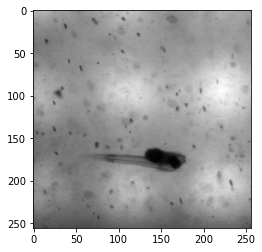

In [19]:
plt.imshow(get_plottable_frame(batch['clip'][2,:,99,:,:]),cmap='gray')

In [28]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 2466-EC75

 Directory of C:\Users\Shir\Documents\GitHub\video_autoencoder

24/11/2020  16:12    <DIR>          .
24/11/2020  16:12    <DIR>          ..
22/11/2020  23:49             1,928 .gitignore
22/11/2020  23:49    <DIR>          .idea
22/11/2020  23:53    <DIR>          .ipynb_checkpoints
23/11/2020  11:09             4,374 AuxiliaryFunctions.py
22/11/2020  23:49             2,538 Net.py
22/11/2020  23:49                79 README.md
24/11/2020  16:12            38,449 TrainingNotebook.ipynb
22/11/2020  23:49             2,859 VideoDataset.py
22/11/2020  23:49             2,280 VideoTransforms.py
24/11/2020  14:10    <DIR>          __pycache__
               7 File(s)         52,507 bytes
               5 Dir(s)  181,220,077,568 bytes free


In [22]:
vid1=cv2.VideoCapture(os.path.join(directory,'vid1.avi'))
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
vid_writer = cv2.VideoWriter(os.path.join(directory,'vid2.avi'), fourcc, 30,
                                     (int(vid1.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid1.get(cv2.CAP_PROP_FRAME_HEIGHT))), True)
for i in range(150):
    ret,frame = vid1.read()


In [24]:
while ret:
    ret,frame = vid1.read()
    vid_writer.write(frame)
vid1.release()
vid_writer.release()

In [45]:
vid1=cv2.VideoCapture(os.path.join(directory,'cutout_frame1287009fish2.avi'))

In [43]:
directory=str(Path('G:/My Drive/PhD/regularvid'))#'/Volumes/GoogleDrive/My Drive/PhD/fish_vid'#
#'/Volumes/GoogleDrive/My Drive/PhD/cut_swim_samples'
ds=VideoDataset(directory,num_frames=20, 
                transform=transforms.Compose([Rescale(256),ToTensor()]),swim_sample=False)
dataloader = DataLoader(ds, batch_size=1,
                        shuffle=False, num_workers=4)
samp=ds[0]['clip'].to(device)
samp = samp[np.newaxis,:,:,:,:]

In [60]:
path=
#'/Volumes/GoogleDrive/My Drive/PhD/fish_vid/set learning rate wo weight decay/model_overfit_261120_20frms_epoch1999.pt'
#'/Volumes/GoogleDrive/My Drive/PhD/regularvid/model_overfit_291120_20frms_epoch2999.pt'#str(Path('G:/My Drive/PhD/regularvid/model_overfit_291120_20frms_epoch2999.pt'))
checkpoint=torch.load(path,map_location=torch.device('cpu'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(color_channels=1)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [61]:
with torch.no_grad():
    recon = model(samp)

In [62]:
clip=recon.cpu()

In [58]:
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
vid_writer=cv2.VideoWriter(os.path.join(directory,'samp2.avi'), fourcc, 30,
                                     (clip.shape[-1]*2,clip.shape[-2]), False)

In [56]:
clip.shape

torch.Size([1, 1, 20, 256, 256])

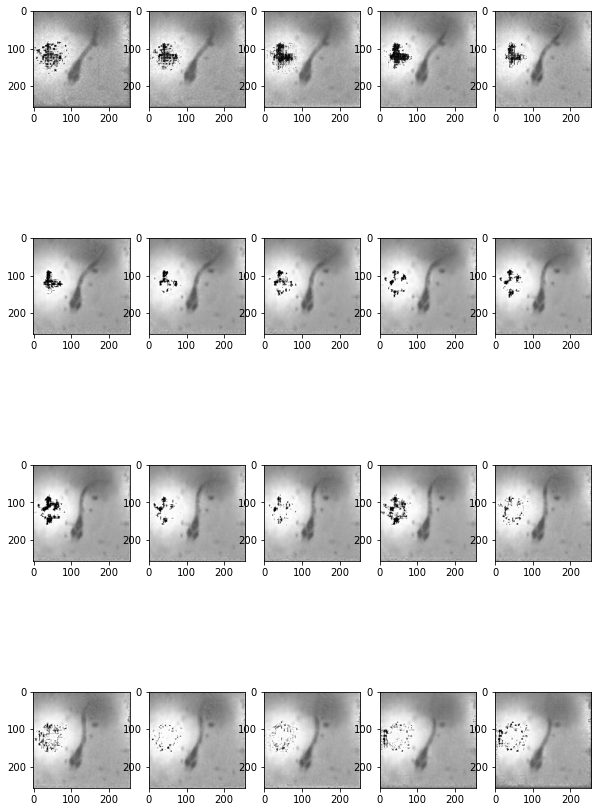

In [59]:
plt.figure(figsize=(10,16))
for i in range(1,clip.shape[2]+1):

    frame=(get_plottable_frame(samp[0,:,i-1,:,:])*255).astype(np.uint8)
    recon_frame=(get_plottable_frame(clip[0,:,i-1,:,:])*255).astype(np.uint8)
    con_frame = np.concatenate((frame,recon_frame),axis=1)
    plt.subplot(4,5,i)
    plt.imshow((recon_frame),cmap='gray')
    vid_writer.write(con_frame)
vid_writer.release()

In [57]:
directory=str(Path('G:/My Drive/PhD/regularvid/holdout'))#'/Volumes/GoogleDrive/My Drive/PhD/regular_vid'#
#'/Volumes/GoogleDrive/My Drive/PhD/cut_swim_samples'
ds=VideoDataset(directory,num_frames=20, 
                transform=transforms.Compose([Rescale(256),ToTensor()]),swim_sample=False)
dataloader = DataLoader(ds, batch_size=1,
                        shuffle=False, num_workers=1)

1

In [70]:
get_plottable_frame(clip[0,:,i-1,:,:]).shape

(452, 256)

In [9]:
def load_loss(directory):
    train_loss={}
    val_loss={}
    for root,directories,files in os.walk(directory):
        for file in files:
            if file.endswith('.pt'):
                filepath = os.path.join(root,file)
                chkpt = torch.load(filepath)
                train_loss[chkpt['epoch']] = chkpt['train_loss']
                val_loss[chkpt['epoch']] = chkpt['val_loss']
    return train_loss, val_loss

In [10]:
run_loss,val_loss=load_loss(str(Path('G:/My Drive/PhD/Fishbase/SwimVSFeed/New_DB/models/ds_optical_flow_fish2')))

In [10]:
run_loss

{0: 0.47326685319905265,
 1: 0.15352876405185242,
 2: 0.09262993109978711,
 3: 0.07485184358104915,
 4: 0.06342806983924783,
 5: 0.056629264201238705,
 6: 0.05178496505186407,
 7: 0.05257703946822902,
 8: 0.04589856097914056,
 9: 0.04402071134840135,
 10: 0.04115004297902814,
 11: 0.04222180251267265,
 12: 0.04234343951574196,
 13: 0.038276520579360256,
 14: 0.04145163043937414,
 15: 0.03792764372702849,
 16: 0.035416041473019556,
 17: 0.03558451168709419,
 18: 0.03440186240249298,
 19: 0.03413506583666485,
 20: 0.0328810885919883,
 21: 0.03356775343170594,
 22: 0.03240074057045371,
 23: 0.031636192713960065,
 24: 0.031009397843846452,
 25: 0.03237945630997915,
 26: 0.03128731713020722,
 27: 0.030600609765248837,
 28: 0.03326439231238096,
 29: 0.031121683699942112,
 30: 0.03441679336600922,
 31: 0.029990302225531534,
 32: 0.02995126321292993,
 33: 0.029318218004960952,
 34: 0.028153764442896526,
 35: 0.030797645653848633,
 36: 0.028121182725972114,
 37: 0.02872795451964651,
 38: 0.0285

In [40]:
l2_set_lr_weight_decay2=OrderedDict(sorted(run_loss.items(), key=lambda t: t[0]))

In [51]:
l2_set_lr_weight_decay[3999]


0.0037797868717461824

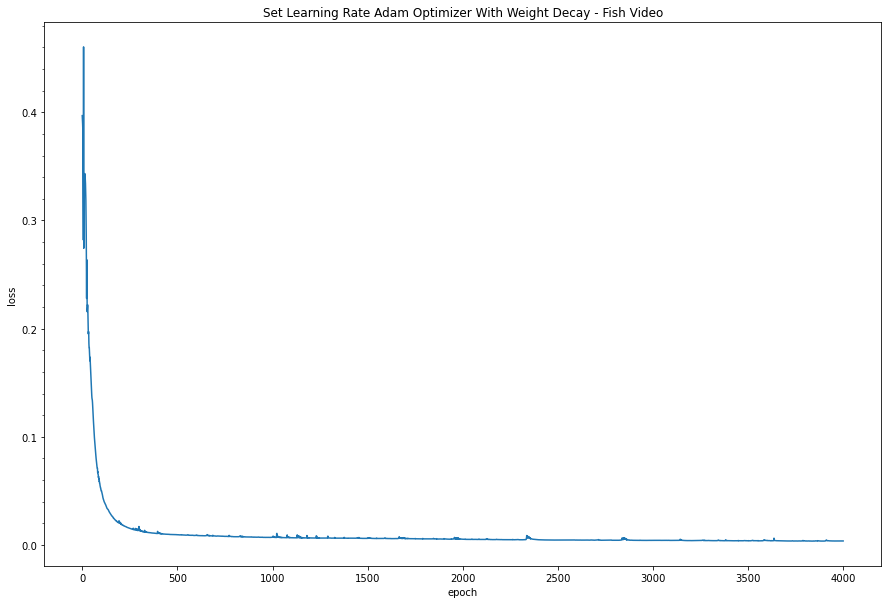

In [56]:

fig,ax = plt.subplots()
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(list(l2_set_lr_weight_decay.keys()),(list(l2_set_lr_weight_decay.values())))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Set Learning Rate Adam Optimizer With Weight Decay - Fish Video')

ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.scatter(100,set_lr_adam_fish_loss[100],color='r')
#plt.savefig('/Volumes/GoogleDrive/My Drive/PhD/fish_vid/setlradamloss.png',dpi=300)

In [11]:
def save_losses_dict(losses,filename):
    a_file = open(f'{filename}.pkl', "wb")
    pickle.dump(losses, a_file)
    a_file.close()


In [8]:
def load_losses_dict(filename):
    a_file = open(f'{filename}.pkl', "rb")
    output = pickle.load(a_file)
    print(output)
    return output

In [52]:
save_losses_dict(l2_set_lr_weight_decay,os.path.join(str(Path('G:/My Drive/PhD//regularvid2/')),
                                                    'l2_set_lr_weight_decay_full'))

In [53]:
trial=load_losses_dict(os.path.join(str(Path('G:/My Drive/PhD//regularvid2/')),
                                                    'l2_set_lr_weight_decay_full'))

OrderedDict([(0, 0.39687344431877136), (1, 0.3932913839817047), (2, 0.3893626630306244), (3, 0.3838210105895996), (4, 0.37094059586524963), (5, 0.33456259965896606), (6, 0.28192970156669617), (7, 0.4604070782661438), (8, 0.2743145227432251), (9, 0.29532480239868164), (10, 0.32086360454559326), (11, 0.3345245122909546), (12, 0.34087902307510376), (13, 0.34328630566596985), (14, 0.3432748317718506), (15, 0.34159645438194275), (16, 0.3385150730609894), (17, 0.33404043316841125), (18, 0.32781699299812317), (19, 0.3189663589000702), (20, 0.3059583306312561), (21, 0.2862403392791748), (22, 0.25751522183418274), (23, 0.22792638838291168), (24, 0.26363086700439453), (25, 0.23749300837516785), (26, 0.21566708385944366), (27, 0.21839173138141632), (28, 0.2221539318561554), (29, 0.2207411527633667), (30, 0.21398407220840454), (31, 0.203652486205101), (32, 0.195068821310997), (33, 0.19737257063388824), (34, 0.1958564966917038), (35, 0.18624384701251984), (36, 0.1825200915336609), (37, 0.1825046539

In [54]:
len(trial)

4000

In [ ]:
nn.Conv3